#### Example: Classification with decision tree

In this example, we train a VAE on the digits dataset from the scikit-learn library.

In [1]:
# PyTorch packages:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pdb

In [2]:
# load digits
from sklearn import datasets
digits = datasets.load_digits()
features = digits.data
labels = digits.target
full_images = digits.images

In [3]:
print(features.shape)

(1797, 64)


In [4]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

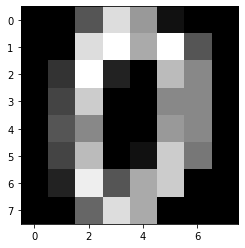

In [5]:
plt.imshow(full_images[0], cmap='gray')
plt.show()

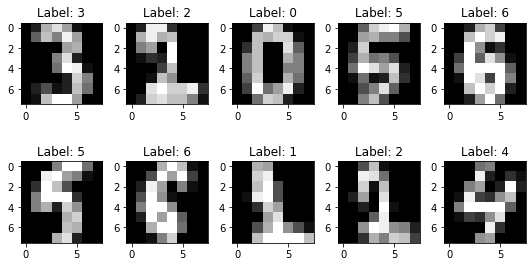

In [6]:
# plot examples of digits
ncol = 5
nrow = 2

samples = np.random.choice(labels.shape[0], size=(nrow,ncol), replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(1.5*ncol,2*nrow))

for idx_row, row in enumerate(axes):
    for idx_ax, ax in enumerate(row):
        ax.imshow(full_images[samples[idx_row,idx_ax]], cmap='gray')
        ax.set_title('Label: {}'.format(labels[samples[idx_row,idx_ax]]))

plt.tight_layout()
plt.show()

For this example, we use a recurrent neural network (RNN) structure for both the variational encoder and decoder.

In [7]:
class VariationalRNNCoder(nn.Module):
    def __init__(self, nInputs, nLayers, nNodes, nOutputs):
        super(VariationalRNNCoder, self).__init__()
        
        self.nLayers = nLayers
        self.nNodes = nNodes
        self.nOutputs = nOutputs

        # RNN Layer
        self.rnn_layers = nn.RNN(nInputs, nNodes, nLayers, batch_first=True, nonlinearity='relu')   
        # fully connected layer
        self.output_layer = nn.Linear(nNodes, int(nOutputs + nOutputs*(nOutputs+1)/2))
        
        
    def forward(self, x):
        batch_size = x.shape[0]

        # initialize hidden state for first input
        hidden = self.init_hidden(batch_size)

        # pass input and hidden state into the model
        y, hidden = self.rnn_layers(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        y = y.contiguous().view(-1, self.nNodes)
        y = self.output_layer(y)
        
        mu = y[:,:self.nOutputs]
        
        # remaining generate the covariance
        U = torch.zeros((mu.shape[0], self.nOutputs, self.nOutputs))
        tril_indices = torch.tril_indices(row=self.nOutputs, col=self.nOutputs, offset=0)
        U[:,tril_indices[0], tril_indices[1]] = y[:,self.nOutputs:]    
        I = torch.zeros(U.shape)
        rng = range(U.shape[1])
        I[:,rng,rng] = 1
        Sigma = torch.matmul(U, torch.transpose(U,1,2)) + 1e-3* I     
        
        return mu, Sigma
        
    def init_hidden(self, batch_size):
        # generate the first hidden state 
        hidden = torch.zeros(self.nLayers, self.nNodes)
        return hidden

The second plot in the following function allows us to investigate the relationship between the latent variables and the different digits. We plot the latent variable space and color the each observation with their corresponding label.

In [8]:
def diagnostic_plots(epoch, loss_hist, encode_net, decode_net):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    # compute moving average of losses
    n = 100
    MA = np.mean(np.array([loss_hist[i:i+n] for i in range(len(loss_hist)-n)]), axis=1)    
    
    axes[0].plot(MA)
    axes[0].set_yscale('log')
    axes[0].set_xlabel('iteration',fontsize=16)
    axes[0].set_ylabel('loss',fontsize=16)
    
    # show latent variable spaces
    batch = torch.tensor(features).float()
    
    mu_q, Sigma_q = encode_net(batch)
    Z = torch.distributions.MultivariateNormal(mu_q, Sigma_q)
    z = Z.rsample().detach().numpy()
    
    temp = axes[1].scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
    plt.colorbar(temp)
    
    fig.suptitle("Epoch:" + str(epoch), fontsize=20)
    plt.show()

In [9]:
def KL(x, encode_net):
    # compute KL[ Q(Z|X=x) | P(Z) ], where P(Z)  is standard indepedent normal
    
    # the variational approximation of the posterior Q(Z|X=x)
    mu_q, Sigma_q = encode_net(x)
    
    # the dimension of the latent variables
    d = mu_q.shape[1]      

    # log ( det Sigma_q )
    A = torch.log( torch.det(Sigma_q)  ) 
    
    # Tr( Sigma_q )
    C = torch.einsum('ijj->i',Sigma_q)
    
    # mu_q' mu_q
    D = torch.einsum('ij,ij->i', mu_q, mu_q)
    
    return torch.mean(0.5* ( -A -d + C + D ))

def ReconLoss(x, encode_net, decode_net):
        # estimate E^{Q[Z|X=x]}[ log P(X=x | Z ) ]
        
        # encode x's to find mean/cov for Z
        mu_q, Sigma_q = encode_net(x)
        Z = torch.distributions.MultivariateNormal(mu_q, Sigma_q)
        z = Z.rsample()
        
        # decode the z's to find mean/cov for X
        #####x_hat = decode_net(z)        
        mu_p, Sigma_p = decode_net(z)
        
        # compute log_prob evaluated at observerd data
        X = torch.distributions.MultivariateNormal(mu_p, Sigma_p)
        
        return torch.mean( X.log_prob(x) )      

def ELBO(x, encode_net, decode_net):
    
    return ReconLoss(x, encode_net, decode_net) - KL(x, encode_net)

In [10]:
def Fit_VAE_Net(encode_net, decode_net, Nepochs = 1_000):
       
    mini_batch_size = 50

    # create  optimizer
    encode_optimizer = optim.Adam(encode_net.parameters())
    decode_optimizer = optim.Adam(decode_net.parameters())

    loss_hist = []
    
    for epoch in range(Nepochs):  # loop over the dataset multiple times
        
        # grab a mini-batch of data
        idx = np.random.randint(0, features.shape[0], mini_batch_size)
        batch = torch.tensor(features[idx,...]).float()

        # zero the parameter gradients
        encode_optimizer.zero_grad()
        decode_optimizer.zero_grad()
        
        # compute the loss associated with this output
        loss = -ELBO(batch, encode_net, decode_net)
        
        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        encode_optimizer.step()
        decode_optimizer.step()                

        loss_hist.append( loss.item() )
        
        print("\rEpoch: {:5d} Average of last 100: {:.2f}".format(epoch + 1, np.mean(loss_hist[-100:])), end="")
        
        # plot output every 1000 iterations
        if( ( (epoch) % 1000 == 0) and (epoch>10) ):
            diagnostic_plots(epoch, loss_hist, encode_net, decode_net)
                
    diagnostic_plots(epoch, loss_hist, encode_net, decode_net)
    print('Finished Training')
    
    return loss_hist

In [11]:
nLatent = 2
encode_net = VariationalRNNCoder(nInputs=64, nLayers=2, nNodes=64, nOutputs=nLatent)
decode_net = VariationalRNNCoder(nInputs=nLatent, nLayers=2, nNodes=64, nOutputs=64)

We must mention that with this number of epochs and only two latent variables, this model should not be able to fully characterize this dataset. However, we observe that the points that are similar tend to group together in the latent space.

Epoch:  1001 Average of last 100: 561.10802

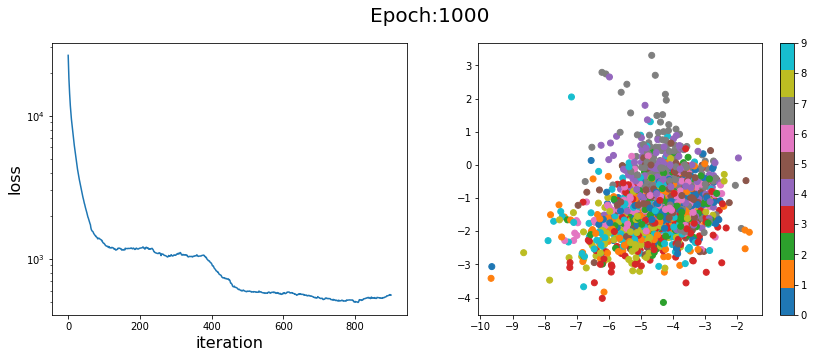

Epoch:  2001 Average of last 100: 241.38

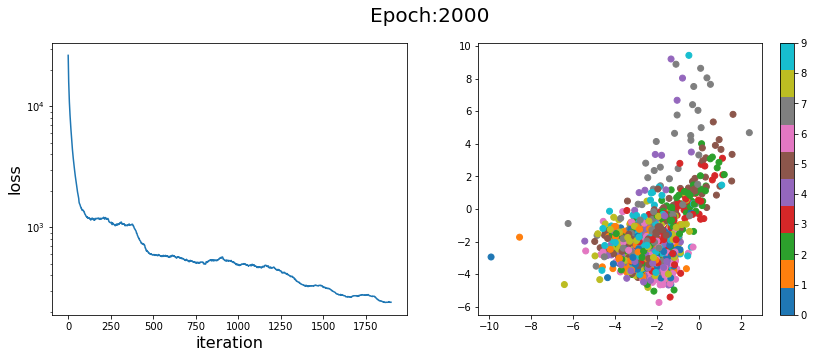

Epoch:  3001 Average of last 100: 171.22

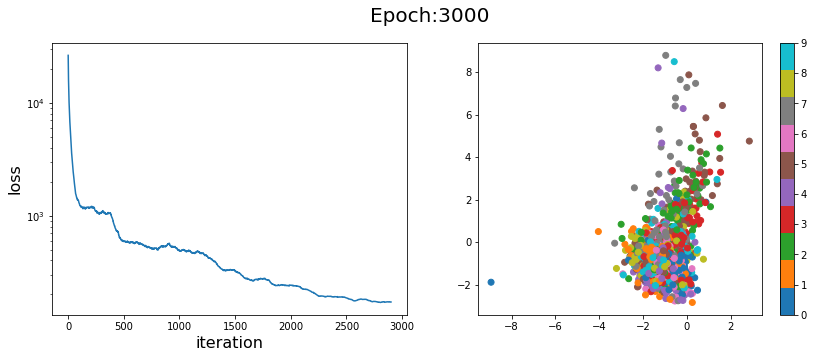

Epoch:  4001 Average of last 100: 141.21

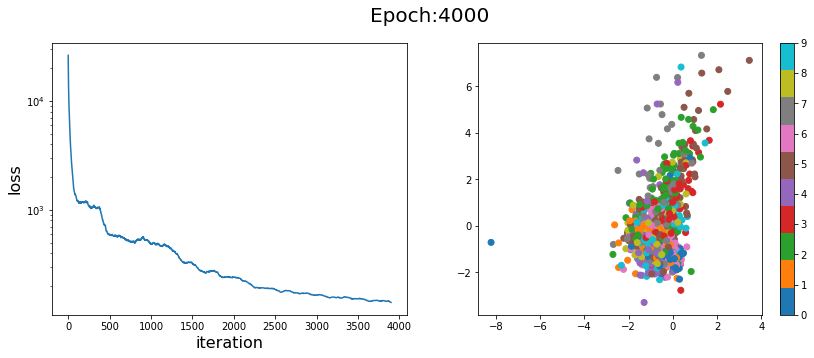

Epoch:  5001 Average of last 100: 129.94

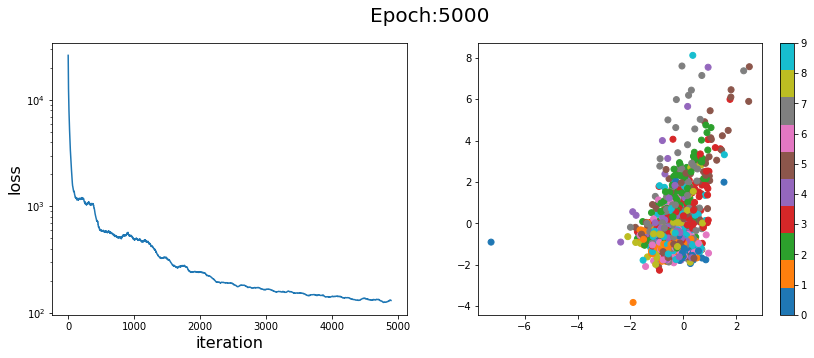

Epoch:  6001 Average of last 100: 117.54

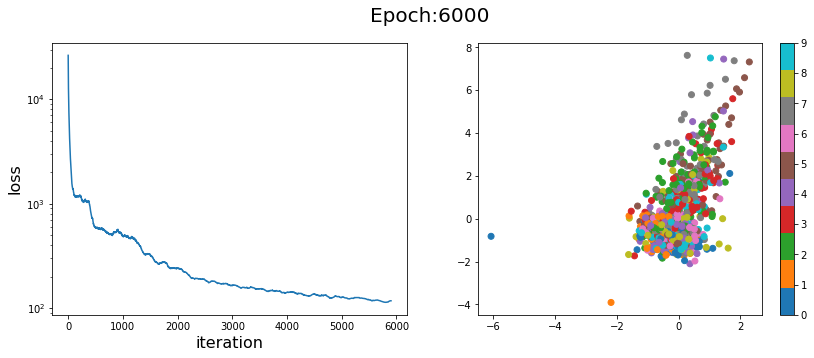

Epoch:  7001 Average of last 100: 109.66

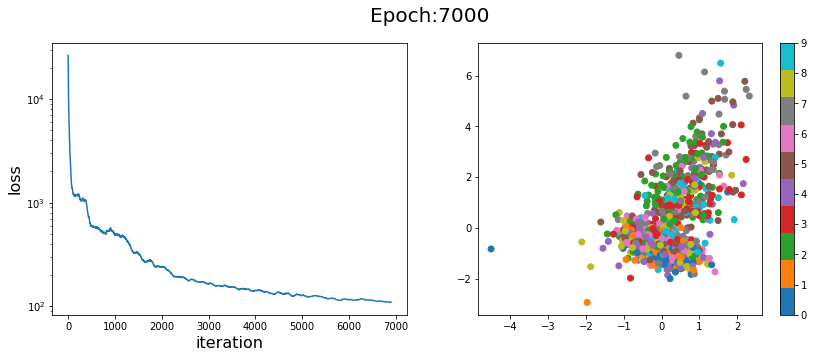

Epoch:  8001 Average of last 100: 103.13

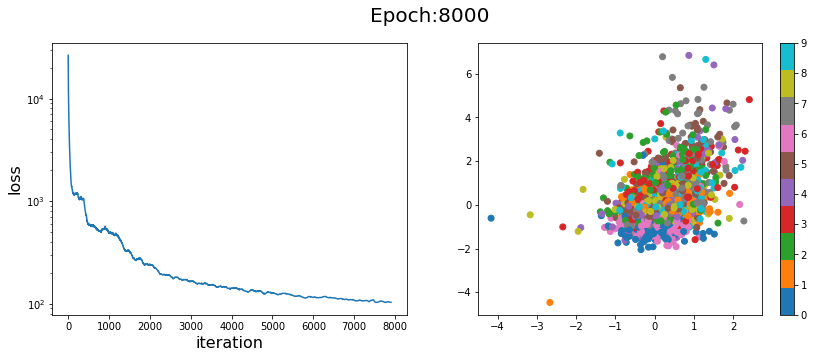

Epoch:  9001 Average of last 100: 97.894

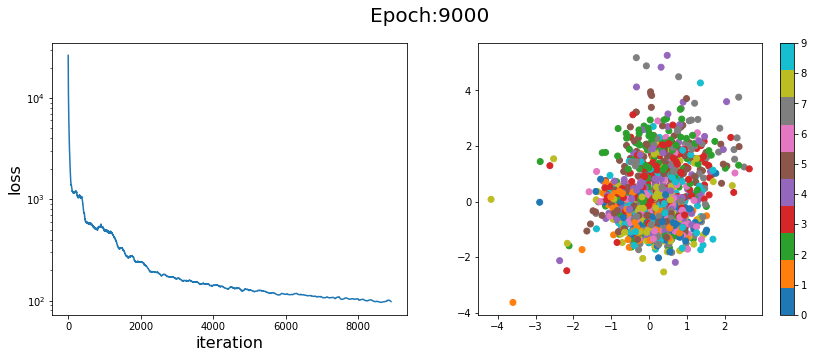

Epoch: 10001 Average of last 100: 98.203

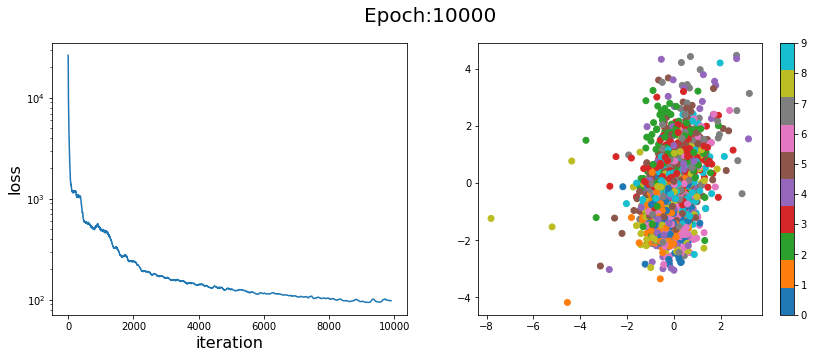

Epoch: 11001 Average of last 100: 91.00

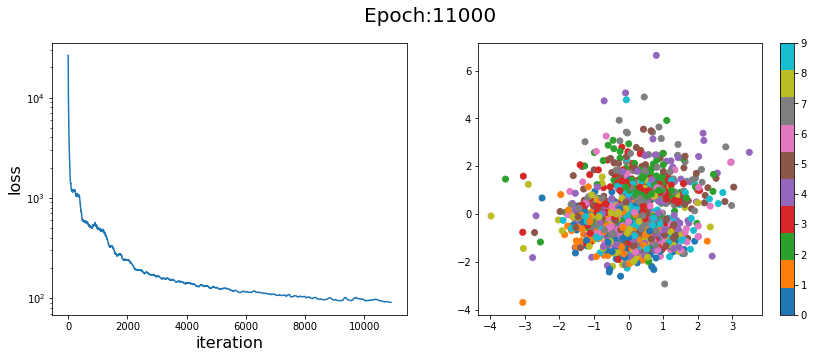

Epoch: 12001 Average of last 100: 89.83

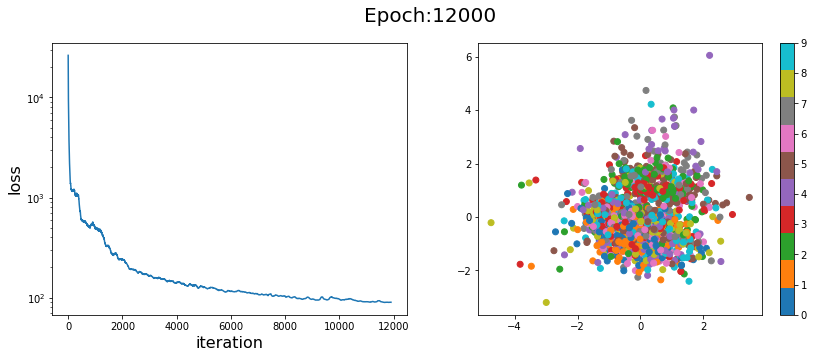

Epoch: 13001 Average of last 100: 96.73

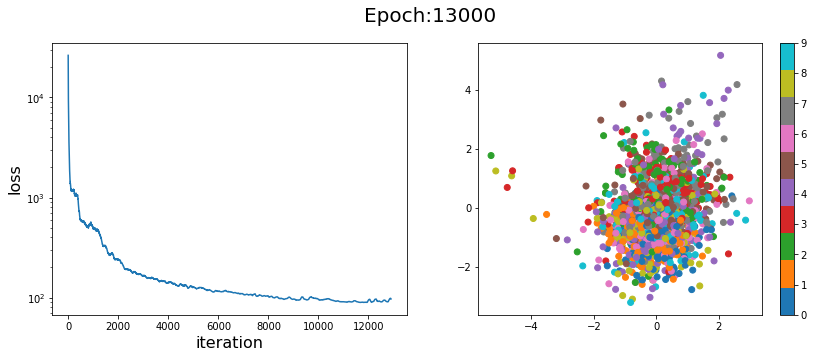

Epoch: 14001 Average of last 100: 89.14

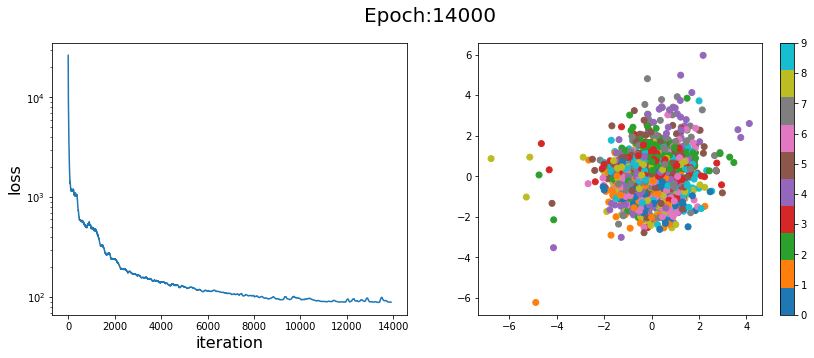

Epoch: 15001 Average of last 100: 91.00

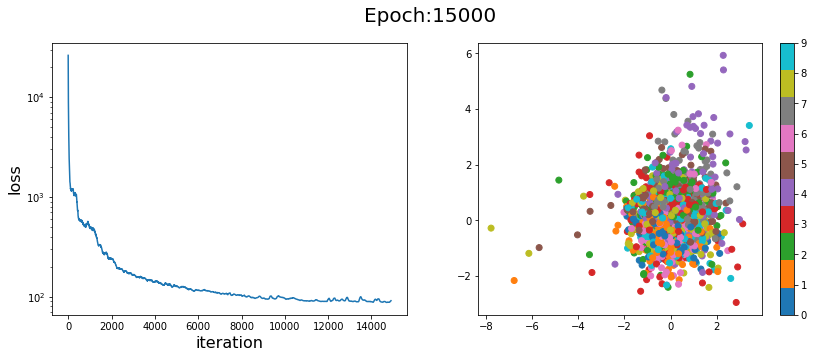

Epoch: 16001 Average of last 100: 86.84

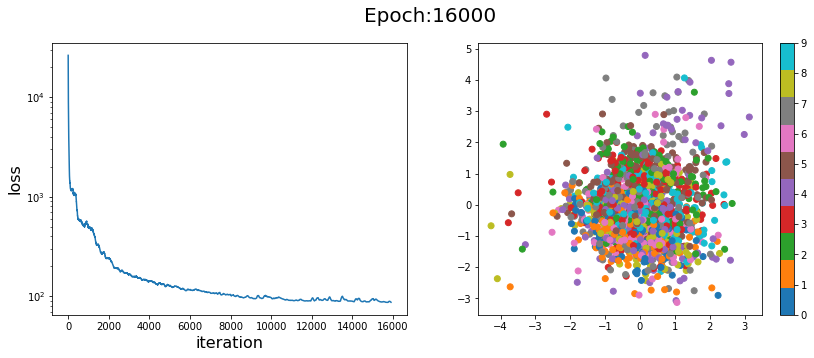

Epoch: 17001 Average of last 100: 87.86

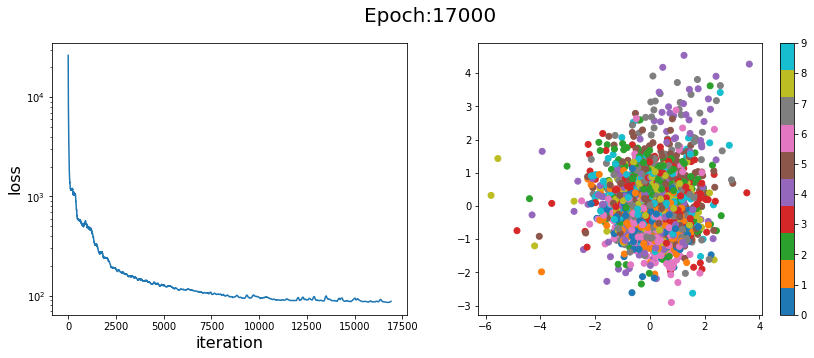

Epoch: 18001 Average of last 100: 85.81

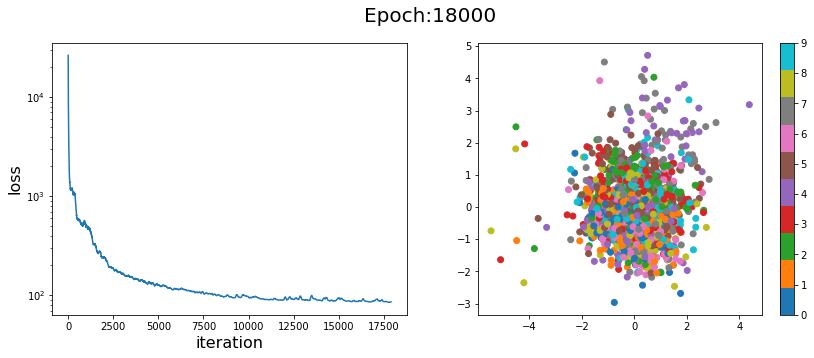

Epoch: 19001 Average of last 100: 85.43

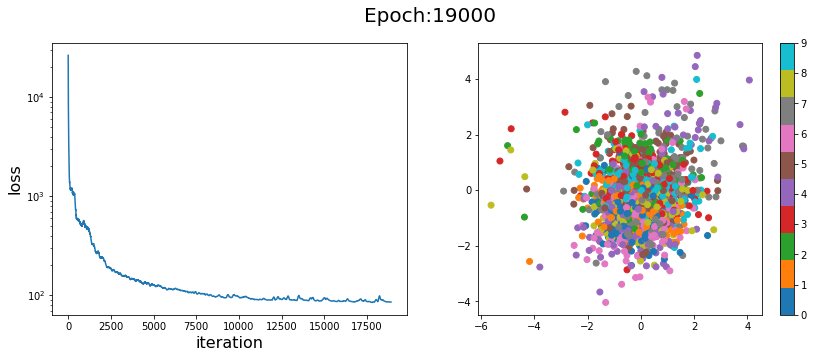

Epoch: 20000 Average of last 100: 84.59

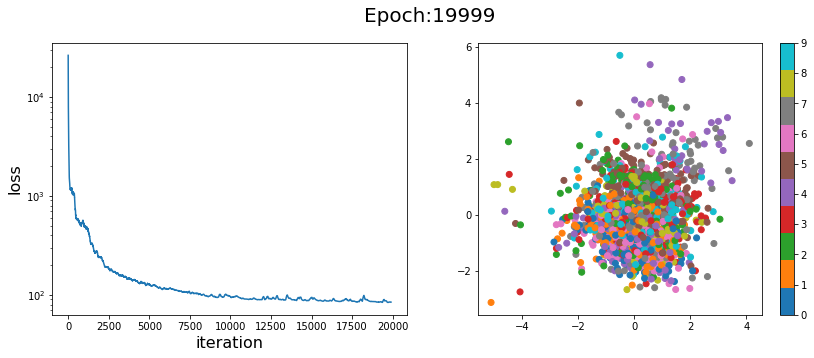

Finished Training


In [12]:
loss_hist = Fit_VAE_Net(encode_net, decode_net,  Nepochs = 20_000)

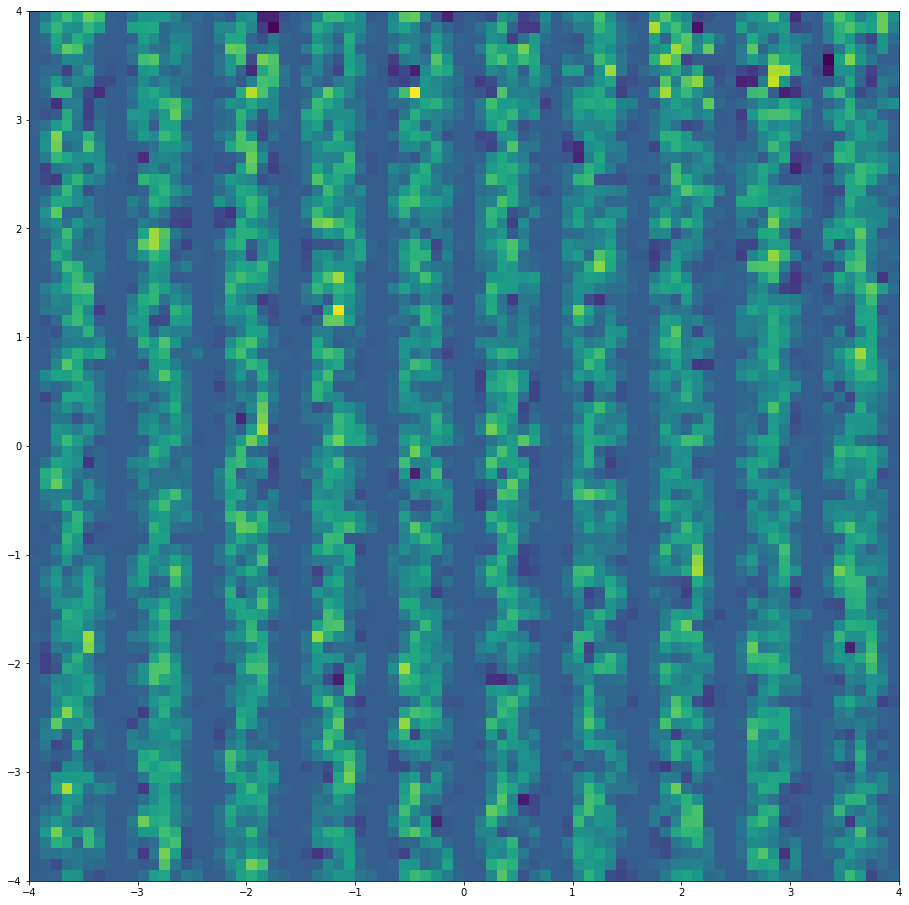

In [13]:
r0 = (-4, 4)
r1 = (-4, 4)
n = 10
w = 8
img = np.zeros((n*w, n*w))
for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]])
        mu_p, Sigma_p = decode_net(z)
        Z = torch.distributions.MultivariateNormal(mu_p, Sigma_p)
        x_hat = Z.rsample()
        
        x_hat = x_hat.reshape(w, w).detach().numpy()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

plt.figure(figsize=(16,16))        
plt.imshow(img, extent=[*r0, *r1])
plt.show()